A notebook to generate the skygrid from a BEAST log file, and grab the skyline from a single simulation. Pulling Skygrid from log file adapted from an R script created by Mandev Gill.

Contains plots.

At the end, also has comparison for fitting the skyline to the skygrid through KDEs and regression

In [1]:
get_ipython().magic('matplotlib inline')

import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from collections import OrderedDict

In [81]:
path = "/Users/s1743989/VirusEvolution Dropbox/Verity Hill/Agent_based_model/"

#Specified in BEAST XML
logpop_length = 21 
skygrid_cutoff = 0.4

#Most recently sampled sequence
most_recent_obs = 2014.74

#This is always the same - when the logpops start to be recorded in the BEAST log file
start = 7

# log_file = path + '1284_subtree/1284_skygrid.log'
# output_file = path + '1284_subtree/skygridplot.pdf'

log_file = path + 'Observed_data/option_C/optionC.log'
output_file = path + 'Observed_data/option_C/skygrid.pdf'

skyline_file = path + "Looping models/Results/LTT_runs/1/skylines/skyline_for_95.csv"

LTT_file = path + "Looping models/Results/LTT_runs/1/lineages/ltt_for_95.csv"

date_file = path + "Looping models/Results/LTT_runs/1/most_recent_dates.csv"


#This can be changed, but usually 10% is about right
burn_in = 10 #in percent

# Skygrid

### Getting pop sizes

In [3]:
#Get the rows of the log file that contains the logpop measurements
def skygrid_prep(log_file, burn_in):

    count = 0

    with open(log_file) as f:
        next(f)
        next(f)
        next(f)
        next(f)
        next(f)
        for l in f:
            count += 1
            cols = l.strip("\n").split("\t")
            width = len(cols)

    length = count

    dimensions = (length, width)

    end_iteration = dimensions[0]

    begin_iteration = int(round(end_iteration/burn_in, 0))
    
    return end_iteration, begin_iteration


In [4]:
#Get the columns of the log file that contains logpops
def get_cols(log_file, end_iteration, begin_iteration, logpop_length):

    count2 = 0
    count3 = 0
    skygrid = defaultdict(list)

    skygrid_cols = [i for i in range(1,logpop_length + 1)]
    rows = []

    with open(log_file) as f:
        next(f)
        next(f)
        next(f)
        next(f)
        next(f)
        for l in f:
            count2 += 1
            if count2 >= begin_iteration and count2 <= end_iteration:
                count3 += 1
                cols = l.strip("\n").split("\t")
                cols_wanted = cols[start:start+logpop_length+1]
                #print(len(cols_wanted))
                #if count2 == begin_iteration + 2 or count2 == begin_iteration + 3:
                for item in skygrid_cols:
                    #print(item)
                    skygrid[item].append(float(cols_wanted[item]))
                #rows.append(cols_wanted)

    #print(count3)
     
    return skygrid

In [5]:
#Pull out the logpop measurements from the logfile
def log_pops(skygrid):

    mean_dict = {}
    lower_dict = {}
    upper_dict = {}

    for key, value in skygrid.items():
        mean_dict[key] = (sum(value)/len(value))
        lower_dict[key] = np.percentile(value, 2.5)
        upper_dict[key] = np.percentile(value, 97.5)
        
    mean_list = []
    lower_list = []
    upper_list = []

    for value in mean_dict.values():
        mean_list.append(value)
    for value in lower_dict.values():
        lower_list.append(value)
    for value in upper_dict.values():
        upper_list.append(value)

    revmean = list(reversed(mean_list))
    revlower = list(reversed(lower_list))
    revupper = list(reversed(upper_list))

    return revmean, revlower, revupper, mean_list, lower_list, upper_list
        

In [6]:
#In case you want non-logged population sizes
def e_pops(skygrid):

    meane_dict = {}
    lowere_dict = {}
    uppere_dict = {}

    for key, value in skygrid.items():
        meane_dict[key] = math.exp(sum(value)/len(value))
        lowere_dict[key] = math.exp(np.percentile(value, 2.5))
        uppere_dict[key] = math.exp(np.percentile(value, 97.5))

    meane_list = []
    lowere_list = []
    uppere_list = []

    for value in meane_dict.values():
        meane_list.append(value)
    for value in lowere_dict.values():
        lowere_list.append(value)
    for value in uppere_dict.values():
        uppere_list.append(value)

    revemean = list(reversed(meane_list))
    revelower = list(reversed(lowere_list))
    reveupper = list(reversed(uppere_list))
    
    return meane_list, lowere_list, uppere_list

In [7]:
#Combining all - will return the mean logpop at each timepoint (minus burn-in), with lower and upper bounds, forwards in time

def get_pop_sizes(log_file, burn_in, logpop_length):
    
    step1 = skygrid_prep(log_file, burn_in)
    
    step2 = get_cols(log_file, step1[0], step1[1], logpop_length)
    
    step3 = log_pops(step2)
    
    return step3
    

In [8]:
output = get_pop_sizes(log_file, burn_in, logpop_length)

revmean = output[0]
revlower = output[1]
revupper = output[2]
means = output[3]
lowers = output[4]
uppers = output[5]

In [9]:
print(lowers)

[-0.0052984156901952437, 1.1541533876167103, 0.2014440645035874, 0.76624723956549201, 0.59374362107383316, -0.53409349947050955, -0.22408897701052016, -0.74129800668946344, -0.42229912402631054, -0.12441832626468434, 0.15682502116664443, -0.12119188575043421, -1.1633905897362733, -0.92185262726876693, -2.0486597261421182, -2.205905292268441, -3.4479458418361775, -3.2212251505114202, -4.6095680898983282, -5.5363289542056808, -6.9434644343372902]


### Getting gridpoints

In [59]:
#Define the gridpoints from the skygrid so skyline can be forced into the same time structure
def get_gridpoints(end_time, skygrid_cutoff, logpop_length):
    
    begin_time = end_time - skygrid_cutoff

    total_time = end_time - begin_time

    gridpoint_intervals = total_time/logpop_length
    
    gridpoints = []
    new = 0

    for i in range(logpop_length):
        new += gridpoint_intervals
        gridpoints.append(new)

    #print(gridpoints)
    revtimes = list(reversed(gridpoints))

    times_in_years = [end_time - i for i in revtimes]
    times_in_years.append(end_time)
    
    return times_in_years, revtimes, begin_time, end_time



In [1]:
gridpoints = get_gridpoints(most_recent_obs, skygrid_cutoff, logpop_length)

times_in_years = gridpoints[0]
revtimes = gridpoints[1]


NameError: name 'get_gridpoints' is not defined

In [61]:
print(gridpoints[0])
print(gridpoints[1])

[2014.34, 2014.3590476190475, 2014.378095238095, 2014.3971428571429, 2014.4161904761904, 2014.435238095238, 2014.4542857142856, 2014.4733333333334, 2014.492380952381, 2014.5114285714285, 2014.530476190476, 2014.5495238095239, 2014.5685714285714, 2014.587619047619, 2014.6066666666666, 2014.6257142857144, 2014.644761904762, 2014.6638095238095, 2014.682857142857, 2014.7019047619049, 2014.7209523809524, 2014.74]
[0.4000000000000908, 0.3809523809524674, 0.36190476190484405, 0.3428571428572207, 0.3238095238095973, 0.30476190476197396, 0.2857142857143506, 0.2666666666667272, 0.24761904761910386, 0.2285714285714805, 0.20952380952385713, 0.19047619047623376, 0.1714285714286104, 0.15238095238098703, 0.13333333333336367, 0.11428571428574028, 0.0952380952381169, 0.07619047619049352, 0.05714285714287014, 0.03809523809524676, 0.01904761904762338]


# Skyline and LTT prep

In [25]:
#Generates time bins from the gridpoints

bins = []

rev_times_in_years = times_in_years[::-1]

for pos,gp in enumerate(rev_times_in_years):

    if pos+1 < len(rev_times_in_years):

        new_tup = (gp, rev_times_in_years[pos+1])

        bins.append(new_tup)

        
print(bins)
#return bins

[(2014.74, 2014.7209523809524), (2014.7209523809524, 2014.7019047619049), (2014.7019047619049, 2014.682857142857), (2014.682857142857, 2014.6638095238095), (2014.6638095238095, 2014.644761904762), (2014.644761904762, 2014.6257142857144), (2014.6257142857144, 2014.6066666666666), (2014.6066666666666, 2014.587619047619), (2014.587619047619, 2014.5685714285714), (2014.5685714285714, 2014.5495238095239), (2014.5495238095239, 2014.530476190476), (2014.530476190476, 2014.5114285714285), (2014.5114285714285, 2014.492380952381), (2014.492380952381, 2014.4733333333334), (2014.4733333333334, 2014.4542857142856), (2014.4542857142856, 2014.435238095238), (2014.435238095238, 2014.4161904761904), (2014.4161904761904, 2014.3971428571429), (2014.3971428571429, 2014.378095238095), (2014.378095238095, 2014.3590476190475), (2014.3590476190475, 2014.34)]


In [63]:
#Find the most recent bin

most_recent_dates = {}

with open(date_file) as f:
    next(f)
    for l in f:
        toks = l.strip("\n").split(",")
        most_recent_dates[float(toks[0])] = float(toks[1])
        
        
most_recent_sim = most_recent_dates[95]

print(most_recent_sim)
        

138.2710303510009


In [64]:
#Makes the intervals from the simulation real time ie changes "day 10" to 2014.x

def make_intervals_realtime(intervals, most_recent_sim, skygrid_cutoff, most_recent_obs):
    
    start_time = most_recent_obs - skygrid_cutoff
    
    real_time_mostrecent = start_time + (most_recent_sim/365)
    
    new_intervals = []
    
    for tup in intervals:

        in_years_0 = tup[0]/365
        in_years_1 = tup[1]/365

        new_number_0 = real_time_mostrecent - in_years_0
        new_number_1 = real_time_mostrecent - in_years_1 

        new_intervals.append((new_number_0, new_number_1))

    
    return new_intervals

In [65]:
#Combines above functions to force simulated effective population sizes into the same gridpoints as the skygrid


def bin_skyline(input_file, most_recent_sim, gridpoints, skygrid_cutoff, most_recent_obs, logpop_length):
    
    intervals = []
    sizes = []
    bin_dict = defaultdict(list)
    skyline_bins = {}
    skyline_final = OrderedDict()

    with open(input_file) as f:
        next(f)
        for l in f:
            toks = l.strip("\n").split(",")
            start_interval = float(toks[1])
            end_interval = float(toks[2])
            pop_size = float(toks[3])

            intervals.append((start_interval, end_interval))
            sizes.append(pop_size)  
            
            
    rt_intervals = make_intervals_realtime(intervals, most_recent_sim, skygrid_cutoff, most_recent_obs)
    
    for position, interval in enumerate(rt_intervals):

        for bin_position,binn in enumerate(gridpoints):

            if interval[0] == most_recent_obs and binn[0] == most_recent_obs:
                bin_dict[bin_position].append(position)

            #Is it beyond the skygrid
            elif interval[0] < (most_recent_obs - skygrid_cutoff):
                continue
            
            #Is start interval in range
            #Is end interval in range
            #Does the interval straddle a gridpoint

            
            if (interval[0] < binn[0] and interval[0] >= binn[1]) or (interval[1] < binn[0] and interval[1] >= binn[1]) or (interval[0] > binn[0] and interval[1] < binn[1]): 

                bin_dict[bin_position].append(position)


    
    for binn_pos, interval_pos_list in bin_dict.items():

        #print(binn_pos, interval_pos_list)
        
        if len(interval_pos_list) == 1:

            skyline_bins[gridpoints[binn_pos]] = sizes[interval_pos_list[0]]


        elif len(interval_pos_list) == 2:

            Ne_a = sizes[interval_pos_list[0]]
            Ne_b  = sizes[interval_pos_list[1]]

            interval_a = rt_intervals[interval_pos_list[0]][1]

            bin_a = gridpoints[binn_pos][0]
            bin_b = gridpoints[binn_pos][1]


            weight_a = (interval_a - bin_a)/7
            weight_b = 1 - weight_a

            Ne = ((Ne_a*weight_a) + (Ne_b*weight_b))

            skyline_bins[bins[binn_pos]] = Ne


        elif len(interval_pos_list) > 2:

            last_position = len(interval_pos_list) - 1

            Ne_a = sizes[interval_pos_list[0]]
            Ne_b = sizes[interval_pos_list[last_position]]

            other_Nes = [sizes[interval_pos_list[i]] for i in range(1, len(interval_pos_list)-1)]

            interval_a = rt_intervals[interval_pos_list[0]][1]
            interval_b = rt_intervals[interval_pos_list[last_position]][0]        

            bin_a = gridpoints[binn_pos][0]
            bin_b = gridpoints[binn_pos][1]

            weight_a = (bin_a - interval_a)*52
         
            weight_b = (interval_b - bin_b)*52

            other_weights = (1 - weight_a - weight_b)/(len(interval_pos_list)-2)

            final_other_Nes = 0

            for i in other_Nes:
                final_other_Nes += (other_weights*i)

            Ne = ((Ne_a*weight_a) + (Ne_b*weight_b) + final_other_Nes)

            skyline_bins[gridpoints[binn_pos]] = Ne 
            
    for tup in gridpoints:
        if tup not in skyline_bins.keys():
            skyline_bins[tup] = 0
    
    sorted_skyline = sorted(skyline_bins.items())[::-1]
    
    #print(sorted_skyline)
    
    for item in sorted_skyline:
        tup = item[0]
        new_tup = (tup[1], tup[0])
        
        skyline_final[new_tup] = item[1]
            
            
    return skyline_final


In [40]:
skyline_dict = bin_skyline(path + "Looping models/Results/Playing_with_parameters/new_lambda/2/skylines/skyline_for_1.csv", most_recent_date, bins,  skygrid_cutoff, most_recent_tip, logpop_length)



In [66]:
#input_file, most_recent_date, gridpoints, skygrid_cutoff, most_recent_tip, logpop_length


LTT_dict = bin_skyline(LTT_file, most_recent_sim, bins, skygrid_cutoff, most_recent_obs, logpop_length)

## Comparisons

In [70]:
#Combines the simulated skyline and the observed skygrid

def skyline_grid_comparison(log_file, burn_in, logpop_length, skyline_file, most_recent_obs, skygrid_cutoff, most_recent_sim):
    
    skygrid_dict = {}
    
    comparison_dict = defaultdict(tuple)
    
    #Skygrid
    
    output = get_pop_sizes(log_file, burn_in, logpop_length)


    revmean = output[0]
    revlower = output[1]
    revupper = output[2]
    means = output[3]
    lowers = output[4]
    uppers = output[5]
    
    
    gridpoints = get_gridpoints(most_recent_obs, skygrid_cutoff, logpop_length)
    
    times_in_years = gridpoints[0]
        
    times_in_years.remove(2014.74)
    
    for time, Ne in zip(times_in_years, revmean):
        skygrid_dict[time] = Ne
        
        
    
    #Skyline
    
    bins = []

    rev_times_in_years = times_in_years[::-1]

    for pos,gp in enumerate(rev_times_in_years):

        if pos+1 < len(rev_times_in_years):

            new_tup = (gp, rev_times_in_years[pos+1])

            bins.append(new_tup)
    
        
    skyline_values = bin_skyline(skyline_file, most_recent_sim, bins, skygrid_cutoff, most_recent_obs, logpop_length)
    
    for key, value in skygrid_dict.items():
        for tup, Ne in skyline_values.items():
            if tup[0] == key:
                comparison_dict[key] = (value, Ne)
                
    return comparison_dict, skygrid_dict
    
    

In [71]:

comparison = skyline_grid_comparison(log_file, burn_in, logpop_length, LTT_file,  most_recent_obs, skygrid_cutoff, most_recent_sim)



comparison_dict = comparison[0]

skygrid_dict1 = comparison[1]

In [85]:
comparison = skyline_grid_comparison(log_file, burn_in, logpop_length, skyline_file,  most_recent_obs, skygrid_cutoff, most_recent_sim)

comparison_dict2 = comparison[0]

In [87]:
comparison_dict2

defaultdict(tuple,
            {2014.34: (-3.465106356644072, -5.045671793462285),
             2014.3590476190475: (-3.124355834821509, -3.19619547180406),
             2014.378095238095: (-2.7695844951875697, -2.9003692670228487),
             2014.3971428571429: (-1.7512677279326283, -4.591159564139087),
             2014.4161904761904: (-2.492921082631608, -5.1464067485716685),
             2014.435238095238: (-0.8412108049119418, -5.078310088061122),
             2014.4542857142856: (-1.347671661267795, -3.3749845616509653),
             2014.4733333333334: (0.19442638749372584, -3.41596303077043),
             2014.492380952381: (-0.08209462602918038, -5.889418495436348),
             2014.5114285714285: (1.1340366126959343, -5.410950469500188),
             2014.530476190476: (1.3147286111512144, -5.349123635872174),
             2014.5495238095239: (1.1123421606754686, -5.326629551921053),
             2014.5685714285714: (0.665484188119581, -5.657633404357318),
             20

## Plotting together

In [73]:
def plot_skyline(Ne_dict):

    names = list(Ne_dict.keys())
    values = list(Ne_dict.values())

    plt.step(names,values)
    plt.show()

In [74]:
def plot_skygrid(times_in_years, means, lowers, uppers):

    x = times_in_years
    y = means

    plt.xlim(gridpoints[2], gridpoints[3])

    plt.plot(x,y,'-k')
    plt.fill_between(x, lowers, uppers)
    plt.show()

In [75]:
def plot_together(times_in_years, means, revlower, revupper, skyline_dict):
    
        
    x = times_in_years
    y = means
    
    x2 = list(skyline_dict.keys())
    y2 = list(skyline_dict.values())
    
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    

    color = 'tab:blue'
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Real data (skygrid)")
    ax1.plot(x,y,'-k')
    ax1.fill_between(x, lowers, uppers)
    
    color = 'tab:red'
    ax2.set_ylabel("Simulated data (skyline)")
    ax2.step(x2, y2, color=color)
    ax2.tick_params(axis='y')
    



    ax1.tick_params(axis = 'y')
    #ax1.fill_between(x, revlower, revupper)

    fig.set_size_inches(10,10)

    fig.tight_layout()
    plt.show()
    

In [78]:
def plot_together(comparison_dict, revlower, revupper, LTT):
    
    fig = plt.gcf()
    skygrid = []
    skyline = []
    new_lowers = []
    new_uppers = []
    
    if not LTT:
        for value in comparison_dict.values():
            skygrid.append(value[0])
            skyline.append(value[1])
    if LTT:
        for value in comparison_dict.values():
            skygrid.append(value[0])
            skyline.append(np.log(value[1]))
        
    x = list(comparison_dict.keys())
    y = skygrid
    
    x2 = list(comparison_dict.keys())
    y2 = skyline
    
    for i in revlower:
        new_lowers.append(float(i))
    for j in revupper:
        new_uppers.append(float(j))
    
    for l,m,u in zip(new_lowers, skygrid, new_uppers):
        print(l,m,u)
    
    plt.plot(x,y, '-k')
    #plt.fill_between(x, new_lowers, new_uppers)
    plt.step(x2,y2, color = 'red')
    
    fig.set_size_inches(10,10)
    
    
    plt.show()

-6.94346443433729 -3.465106356644072 -1.0388384049912713
-5.536328954205681 -3.124355834821509 -0.8955687893279418
-4.609568089898328 -2.7695844951875697 -0.4335726348162064
-3.22122515051142 -1.7512677279326283 0.8733707782658631
-3.4479458418361775 -2.492921082631608 -1.3577745982899914
-2.205905292268441 -0.8412108049119418 1.54471923261791
-2.048659726142118 -1.347671661267795 -0.5692678029035754
-0.9218526272687669 0.19442638749372584 2.3627869647677096
-1.1633905897362733 -0.08209462602918038 1.2387066239344997
-0.12119188575043421 1.1340366126959343 3.404047399612373
0.15682502116664443 1.3147286111512144 3.6006515495936124
-0.12441832626468434 1.1123421606754686 3.179163130186952
-0.42229912402631054 0.665484188119581 2.3010620263634394
-0.7412980066894634 0.08719608892534998 1.2043217156195904
-0.22408897701052016 0.7811200644951011 2.7042616907581083
-0.5340934994705095 0.08121177731969915 0.8729294550575053
0.5937436210738332 1.752392516547019 3.8810813600691656
0.7662472395

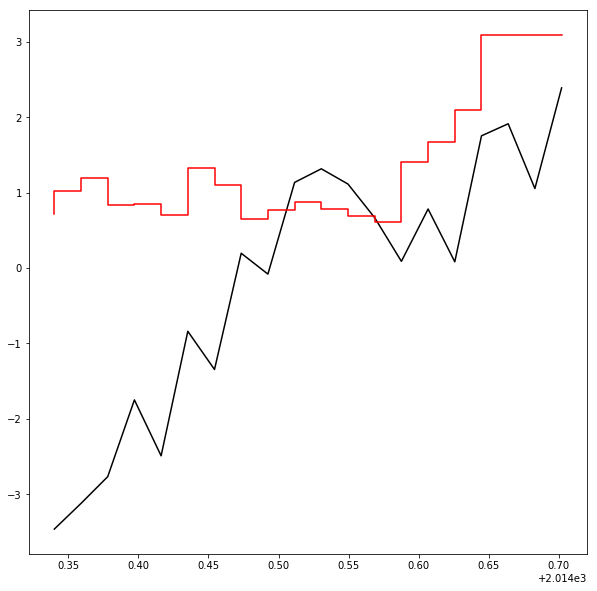

In [79]:
plot_together(comparison_dict, revlower, revupper, True)

-6.94346443433729 -3.465106356644072 -1.0388384049912713
-5.536328954205681 -3.124355834821509 -0.8955687893279418
-4.609568089898328 -2.7695844951875697 -0.4335726348162064
-3.22122515051142 -1.7512677279326283 0.8733707782658631
-3.4479458418361775 -2.492921082631608 -1.3577745982899914
-2.205905292268441 -0.8412108049119418 1.54471923261791
-2.048659726142118 -1.347671661267795 -0.5692678029035754
-0.9218526272687669 0.19442638749372584 2.3627869647677096
-1.1633905897362733 -0.08209462602918038 1.2387066239344997
-0.12119188575043421 1.1340366126959343 3.404047399612373
0.15682502116664443 1.3147286111512144 3.6006515495936124
-0.12441832626468434 1.1123421606754686 3.179163130186952
-0.42229912402631054 0.665484188119581 2.3010620263634394
-0.7412980066894634 0.08719608892534998 1.2043217156195904
-0.22408897701052016 0.7811200644951011 2.7042616907581083
-0.5340934994705095 0.08121177731969915 0.8729294550575053
0.5937436210738332 1.752392516547019 3.8810813600691656
0.7662472395

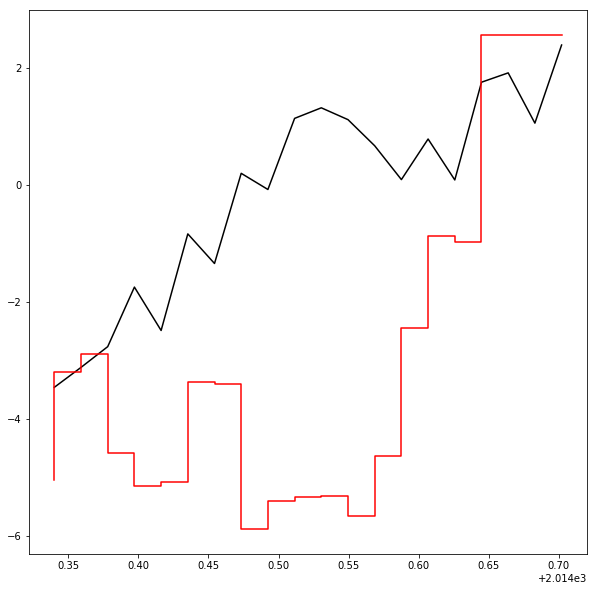

In [88]:
plot_together(comparison_dict2, revlower, revupper, False)

# KDE things - not currently being used, was one idea for fitting

In [116]:
#SO THIS IS NOW BACKWARDS

def prepare_skyline_for_kde(skyline_dict):

    skyline_for_kde = {}

    count = 0

    for v in skyline_dict.values():
        count += 1
        skyline_for_kde[count] = v
        
    return skyline_for_kde



In [254]:
#DON'T RERUN, LEFT HERE SO THAT I CAN FIND IT AGAIN IF I WANT TO DO THE SAME THING LATER ON
for file in os.listdir(directory):

    new_file_name = file[:7] + "_" + file[7:]
    src = directory + file
    dst = directory + new_file_name
    os.rename(src, dst)
    

popsize1
popsize_1
popsize10
popsize_10
popsize11
popsize_11
popsize12
popsize_12
popsize13
popsize_13
popsize14
popsize_14
popsize15
popsize_15
popsize16
popsize_16
popsize17
popsize_17
popsize18
popsize_18
popsize19
popsize_19
popsize2
popsize_2
popsize20
popsize_20
popsize21
popsize_21
popsize3
popsize_3
popsize4
popsize_4
popsize5
popsize_5
popsize6
popsize_6
popsize7
popsize_7
popsize8
popsize_8
popsize9
popsize_9


In [107]:
def get_skygrid_kdes(directory):

    dict_of_dicts = defaultdict(dict)
    
    for file in os.listdir(directory):
        file_popsize = {}
        with open(directory+file) as f:
            next(f)
            for l in f:
                toks = l.strip("\n").split("\t")
                density = float(toks[1])
                pop_size = float(toks[0])

                file_popsize[pop_size] = density
                
        dict_of_dicts[file] = file_popsize
        
    return dict_of_dicts

In [26]:
directory = '/Users/s1743989/VirusEvolution Dropbox/Verity Hill/Agent_based_model/Observed_data/option_C/KDEs/'

skyline_for_kde = prepare_skyline_for_kde(skyline_dict)
dict_of_dicts = get_skygrid_kdes(directory)


In [94]:
#So I need to get the skyline_dict before this for the ABC thing - add in a get skyline function here (ie to force it into gridpoints)
#Split out the get skygrid info so that we don't have to keep opening files in the ABC

def get_kernel(skygrid_dicts, skyline_for_kde, skyline_dict):

    skyline_dens = {}

         
    for key, file_popsize in skygrid_dicts.items():
        
        possibles = []
        position_dict = {}
        key_position = {}
        
        file_number = int(key.split("_")[1])
        #print(file_number)
    
        try:
            value_of_interest = skyline_for_kde[file_number]
        except KeyError:
            continue
        
        print(file_number)
        print("Pop size in skyline = " + str(value_of_interest))
        
        for position, dicti, in enumerate(file_popsize.items()):
            

            position_dict[dicti[0]] = position
            key_position[position] = dicti[0]

            if value_of_interest >= dicti[0]:

                possibles.append(dicti[0])

    
        if len(possibles) == 0:
            final_density = 0.0
        
        else:
                
            lower_bound = max(possibles)
            lower_bound_position = position_dict[lower_bound]

            #print("lower Ne = " + str(lower_bound))
            #print(lower_bound_position)

            if lower_bound_position == len(key_position)-1 and value_of_interest != lower_bound:
                 final_density = 0.0

            elif value_of_interest == lower_bound:
                final_density = file_popsize[lower_bound]

            else:
                higher_bound = key_position[lower_bound_position+1]

                #print("higher Ne = " + str(higher_bound))

                lower_dens = file_popsize[lower_bound]
                higher_dens = file_popsize[higher_bound]

                #print("lower dens = " + str(lower_dens))
                #print("higher dens = " + str(higher_dens))

                pop_diff = abs(higher_bound - lower_bound)
                #print("population difference = " + str(pop_diff))

                prop = (value_of_interest - lower_bound)/pop_diff
                #print("proportion = " + str(prop))

                dens_diff = higher_dens - lower_dens
                #print("difference in density = " + str(dens_diff))

                prop_dens = dens_diff*prop
                #print("proportion density = " + str(prop_dens))

                final_density = lower_dens + prop_dens

                #print("final density for " + str(file_number) + " = " + str(final_density))


            
        skyline_dens[list(skyline_dict.keys())[file_number-1]] = final_density

        print("final density = " + str(final_density))
        
        
    return skyline_dens




In [30]:
def final_product(skyline_dens):
    product = 1
    for v in skyline_dens.values():
        
        product *= v
        
    return product

In [31]:
final_product(skyline_dens)

0.0

In [114]:
dict_of_dicts = get_skygrid_kdes(directory)

skyline_file = path + "Looping models/Results/Playing_with_parameters/new_lambda/2/skylines/skyline_for_1.csv"


In [42]:
print(bins)

[(2014.74, 2014.7209523809524), (2014.7209523809524, 2014.7019047619049), (2014.7019047619049, 2014.682857142857), (2014.682857142857, 2014.6638095238095), (2014.6638095238095, 2014.644761904762), (2014.644761904762, 2014.6257142857144), (2014.6257142857144, 2014.6066666666666), (2014.6066666666666, 2014.587619047619), (2014.587619047619, 2014.5685714285714), (2014.5685714285714, 2014.5495238095239), (2014.5495238095239, 2014.530476190476), (2014.530476190476, 2014.5114285714285), (2014.5114285714285, 2014.492380952381), (2014.492380952381, 2014.4733333333334), (2014.4733333333334, 2014.4542857142856), (2014.4542857142856, 2014.435238095238), (2014.435238095238, 2014.4161904761904), (2014.4161904761904, 2014.3971428571429), (2014.3971428571429, 2014.378095238095), (2014.378095238095, 2014.3590476190475), (2014.3590476190475, 2014.34)]


In [117]:
def get_goodness_of_fit(skyline_file, most_recent_tip, bins, skygrid_dicts): 
    
    #bins are going fully backwards
    
    most_recent_date = most_recent_dates[1]
    
    skyline_dict = bin_skyline(skyline_file, most_recent_date, bins, skygrid_cutoff, most_recent_tip)
    
    print(skyline_dict) 
    #So that is backwards overall but within tups going forwards

    skyline_for_kde = prepare_skyline_for_kde(skyline_dict)
    
    print(skyline_for_kde)
    #That's forwards with replacing the keys with numbers
    
    skyline_dens = get_kernel(skygrid_dicts, skyline_for_kde, skyline_dict)


    goodness_of_fit = final_product(skyline_dens)
    
    
    return goodness_of_fit

In [118]:
get_goodness_of_fit(skyline_file, most_recent_tip, bins, dict_of_dicts)

OrderedDict([((2014.682857142857, 2014.7019047619049), 3.70058848749), ((2014.6638095238095, 2014.682857142857), 3.70058848749), ((2014.644761904762, 2014.6638095238095), 3.70058848749), ((2014.6257142857144, 2014.644761904762), 1.735206895220598), ((2014.6066666666666, 2014.6257142857144), 0.4531121615553575), ((2014.587619047619, 2014.6066666666666), 1.8743403787073671), ((2014.5685714285714, 2014.587619047619), 0.5188167400429309), ((2014.5495238095239, 2014.5685714285714), 0.6826082126622914), ((2014.530476190476, 2014.5495238095239), -0.3028762669917959), ((2014.5114285714285, 2014.530476190476), -0.10815596362160179), ((2014.492380952381, 2014.5114285714285), 0.14751794706388754), ((2014.4733333333334, 2014.492380952381), -0.11121988961007456), ((2014.4542857142856, 2014.4733333333334), -0.13630158906652742), ((2014.435238095238, 2014.4542857142856), -0.8284865751937027), ((2014.4161904761904, 2014.435238095238), -0.28795184184877015), ((2014.3971428571429, 2014.4161904761904), -

0.0

## Regressions

In [181]:
print(skyline_dict)

OrderedDict([((2014.7209523809524, 2014.74), 0), ((2014.7019047619049, 2014.7209523809524), 0), ((2014.682857142857, 2014.7019047619049), 3.70058848749), ((2014.6638095238095, 2014.682857142857), 3.70058848749), ((2014.644761904762, 2014.6638095238095), 3.70058848749), ((2014.6257142857144, 2014.644761904762), 1.735206895220598), ((2014.6066666666666, 2014.6257142857144), 0.4531121615553575), ((2014.587619047619, 2014.6066666666666), 1.8743403787073671), ((2014.5685714285714, 2014.587619047619), 0.5188167400429309), ((2014.5495238095239, 2014.5685714285714), 0.6826082126622914), ((2014.530476190476, 2014.5495238095239), -0.3028762669917959), ((2014.5114285714285, 2014.530476190476), -0.10815596362160179), ((2014.492380952381, 2014.5114285714285), 0.14751794706388754), ((2014.4733333333334, 2014.492380952381), -0.11121988961007456), ((2014.4542857142856, 2014.4733333333334), -0.13630158906652742), ((2014.435238095238, 2014.4542857142856), -0.8284865751937027), ((2014.4161904761904, 2014

In [182]:
print(means)

[1.23480078165738, 2.388363552677752, 1.0527554897007056, 1.9120579958210417, 1.752392516547019, 0.08121177731969915, 0.7811200644951011, 0.08719608892534998, 0.665484188119581, 1.1123421606754686, 1.3147286111512144, 1.1340366126959343, -0.08209462602918038, 0.19442638749372584, -1.347671661267795, -0.8412108049119418, -2.492921082631608, -1.7512677279326283, -2.7695844951875697, -3.124355834821509, -3.465106356644072]


In [183]:
print(len(skyline_dict))
print(len(means))

21
21


In [187]:
pair_list = []

for simulated, observed in zip(skyline_dict.values(), means):
    print(simulated, observed)
    if simulated != 0:
        tup = (simulated, observed)
        pair_list.append(tup)
        
print(pair_list)      

0 1.23480078165738
0 2.388363552677752
3.70058848749 1.0527554897007056
3.70058848749 1.9120579958210417
3.70058848749 1.752392516547019
1.735206895220598 0.08121177731969915
0.4531121615553575 0.7811200644951011
1.8743403787073671 0.08719608892534998
0.5188167400429309 0.665484188119581
0.6826082126622914 1.1123421606754686
-0.3028762669917959 1.3147286111512144
-0.10815596362160179 1.1340366126959343
0.14751794706388754 -0.08209462602918038
-0.11121988961007456 0.19442638749372584
-0.13630158906652742 -1.347671661267795
-0.8284865751937027 -0.8412108049119418
-0.28795184184877015 -2.492921082631608
-0.20339162972848548 -1.7512677279326283
-1.162988267930864 -2.7695844951875697
-0.6115165080883542 -3.124355834821509
-2.525304338571594 -3.465106356644072
[(3.70058848749, 1.0527554897007056), (3.70058848749, 1.9120579958210417), (3.70058848749, 1.752392516547019), (1.735206895220598, 0.08121177731969915), (0.4531121615553575, 0.7811200644951011), (1.8743403787073671, 0.08719608892534998

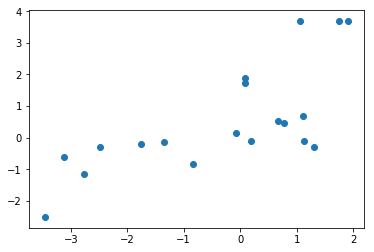

In [196]:
x_prep = []
y_prep = []
for pair in pair_list:
    x_prep.append(pair[1])
    y_prep.append(pair[0])
    
x = np.array(x_prep)
y = np.array(y_prep)
    
plt.scatter(x,y)

In [242]:
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b): 
    # plotting the actual points as scatter plot 
    plt.scatter(x, y, color = "m", 
               marker = "o", s = 30) 
  
    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line 
    plt.plot(x, y_pred, color = "g") 
  
    # putting labels 
    plt.xlabel('x') 
    plt.ylabel('y') 
  
    # function to show plot 
    plt.show() 
    
def main(x,y): 
    # observations  
  
    # estimating coefficients 
    b = estimate_coef(x, y) 
    
    gradient = b[1]
    intercept = b[0]
    
    print(b[0], b[1])

    #So b[0] = c and b[1] = b then
  
    # plotting regression line 
    plot_regression_line(x, y, b) 
    
    return gradient, intercept

0.75616692349 0.714080132221


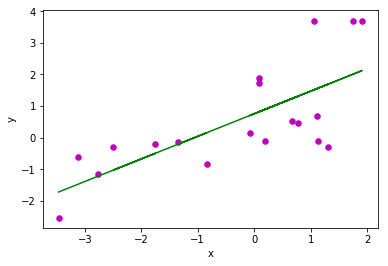

In [247]:
main(x,y)

output = estimate_coef(x,y)
gradient = output[0]
intercept = output[1]

In [252]:
#y_pred
print(gradient)

eqn = gradient*x + intercept

y_pred = []

for value in x:
    y_pred.append(gradient*value + intercept)
    
print(y_pred)

sum_sqs = []

for obs,pred in zip(y, y_pred):
    sq = (obs - pred)**2
    
    
    sum_sqs.append(sq)

print(sum_sqs)
residuals = np.sum(sum_sqs)

print(residuals)

0.75616692349
[1.5101390120544012, 2.1599151444543612, 2.0391813902042228, 0.77548979202754298, 1.3047372882658765, 0.78001493052359139, 1.2172972633819701, 1.5551964817263777, 1.7082344213386125, 1.5716011087674868, 0.65200289142106105, 0.86109893549691674, -0.30498460175447351, 0.077984345864065219, -1.1709843333354488, -0.61017059781694361, -1.3801880548500376, -1.6484544072833349, -1.9061186810473949]
[4.7980689044360911, 2.3736743499406114, 2.7602735429115524, 0.92105691816126878, 0.72526535644470758, 1.1975481865426219, 0.48787504148397809, 0.76141028730825822, 4.0445662007168082, 2.8215838222411622, 0.25450505908306043, 0.94540389765743993, 0.028453958769481778, 0.82168953072331818, 0.77974638102117133, 0.16546912887911086, 0.047175747437734381, 1.0752402067869, 0.38339087848367487]
25.392397399
